<a href="https://colab.research.google.com/github/jina-ai/pqlite/blob/feat-colab-notebook/notebooks/fashion_product_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

<h1>PQLite Powered E-commerce Product Search</h1>

<div align="left">
<a href="https://github.com/jina-ai/pqlite/blob/main/notebooks/fashion_product_search.ipynb" role="button"><img src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/jina-ai/pqlite/blob/main/notebooks/fashion_product_search.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

## What is PQLite?

`PQLite` is an  **Approximate Nearest Neighbor Search** (ANNS) library integrated with the Jina ecosystem.


This indexer is recommended to be used when an application requires **search with filters** applied on `Document` tags.
The `filtering query language` is based on [MongoDB's query and projection operators](https://docs.mongodb.com/manual/reference/operator/query/). We currently support a subset of those selectors.
The tags filters can be combined with `$and` and `$or`:

- `$eq` - Equal to (number, string)
- `$ne` - Not equal to (number, string)
- `$gt` - Greater than (number)
- `$gte` - Greater than or equal to (number)
- `$lt` - Less than (number)
- `$lte` - Less than or equal to (number)

For example, we want to search for a product with a price no more than `50$`.
```python
index.search(query, filter={"price": {"$lte": 50}})
```


## Building a Neural Search System for Ecommerce Product Search

In this tutorial, we will use **pqlite** as indexer to build a neural search engine for images of [Fasion Product Image (Small)](https://www.kaggle.com/paramaggarwal/fashion-product-images-small). This examples allows for **appling filters on various product attributes** when performing similarity search.

![image](https://storage.googleapis.com/kaggle-datasets-images/175990/396802/720cd7ceb25eb130d0b873464f734370/data-original.png)



---

## Preliminaries

**Note**: *Skip this if you've already downloaded them.*


**Download dataset**

In [1]:
!rm -rf data
!pip install gdown
!gdown https://drive.google.com/uc?id=1aMUlWCjIgflBK9dBUU1dB91_zn36_i-p
!unzip fashion.zip -d data > /dev/null

Downloading...
From: https://drive.google.com/uc?id=1aMUlWCjIgflBK9dBUU1dB91_zn36_i-p
To: /content/fashion.zip
100% 593M/593M [00:10<00:00, 56.9MB/s]


**Install dependencies**

In [2]:
!pip install pandas
!pip install Pillow
!pip install matplotlib
!pip install torchvision

!pip install jina
!pip install pqlite

     |████████████████████████████████| 863 kB 8.2 MB/s 
     |████████████████████████████████| 146 kB 53.8 MB/s 
     |████████████████████████████████| 214 kB 58.2 MB/s 
     |████████████████████████████████| 51 kB 727 kB/s 
     |████████████████████████████████| 111 kB 62.7 MB/s 
     |████████████████████████████████| 10.1 MB 26.4 MB/s 
     |████████████████████████████████| 596 kB 72.7 MB/s 
     |████████████████████████████████| 1.8 MB 46.6 MB/s 
     |████████████████████████████████| 3.8 MB 38.5 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 3.6 MB 45.5 MB/s 
     |████████████████████████████████| 1.1 MB 48.6 MB/s 
     |████████████████████████████████| 1.8 MB 42.5 MB/s 
     |████████████████████████████████| 53 kB 2.3 MB/s 
     |████████████████████████████████| 54 kB 3.9 MB/s 
     |████████████████████████████████| 402 kB 50.1 MB/s 
     |████████████████████████████████| 271 kB 48.0 MB/s 
     |████████████████

**Prepare workspace**

In [3]:
!rm -rf workspace
!mkdir workspace

---

# Using **PQLite** in E-Commerce Product Image Search


In [4]:
import os
import glob

import pandas as pd

from PIL import Image
from jina import Document, DocumentArray

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

from pqlite import PQLite

os.environ['JINA_LOG_LEVEL'] = 'DEBUG'

**Prepare Data**

In [5]:
MAX_NUM_DOCS = 200

df = pd.read_csv('/content/data/styles.csv', warn_bad_lines=True, error_bad_lines=False)
df = df.dropna()
df['year'] = df['year'].astype(int)

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

In [6]:
df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013,Casual,Gas Men Caddy Casual Shoe
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011,Casual,Lotto Men's Soccer Track Flip Flop
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011,Casual,Puma Men Graphic Stellar Blue Tshirt
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017,Casual,Rasasi Women Blue Lady Perfume


In [7]:
def get_product_docs(max_num: int = MAX_NUM_DOCS):
    da = DocumentArray()
    for index, row in df.iterrows():
        doc_id = row.pop('id')
        doc_uri = f'/content/data/myntradataset/images/{doc_id}.jpg'

        doc = Document(id=doc_id, uri=doc_uri, tags=dict(row))
        da.append(doc)
        if len(da) == max_num:
            break
    
    return da

In [8]:
docs = get_product_docs(1000)
print(len(docs)) # should be 200

1000


**Preprocess documents**



In [9]:
def preproc(d: Document):
    return (d.load_uri_to_image_blob()  # load
             .set_image_blob_normalization()  # normalize color 
             .set_image_blob_channel_axis(-1, 0))  # switch color axis
docs.apply(preproc)

<docarray.array.document.DocumentArray (length=1000) at 140384128895376>

**Encode image documents**

In [10]:
import torchvision
model = torchvision.models.resnet50(pretrained=True)  # load ResNet50
docs.embed(model, device='cpu', to_numpy=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

<docarray.array.document.DocumentArray (length=1000) at 140384128895376>

**Index documents into PQLite**

In [11]:
# clear the workspace folder
!rm -rf workspace/*

index = PQLite(dim=1000, 
               metric='cosine', 
               columns=[
                        ('year', int), 
                        ('baseColour', str), 
                        ('masterCategory', str)
                ], 
               data_path='./workspace')

index.index(docs)

2021-12-15 04:47:25.039 | DEBUG    | pqlite.container:insert:227 - => 1000 new docs added


In [12]:
befor_year = "2017" #@param [2017, 2018, 2019]
category = "Apparel" #@param ["Apparel", "Footwear"]
color = "Brown" #@param ["White", "Black", "Brown"]



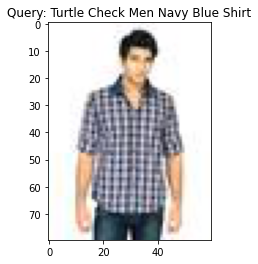

[0] (0.2021896243095398) tags: {'baseColour': 'Brown', 'articleType': 'Tshirts', 'season': 'Fall', 'year': 2011.0, 'gender': 'Men', 'subCategory': 'Topwear', 'masterCategory': 'Apparel', 'productDisplayName': 'Locomotive Men Printed Brown TShirt', 'usage': 'Casual'}


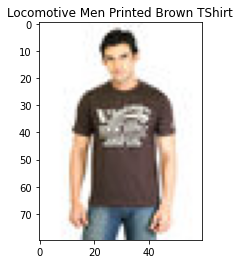

[1] (0.22626632452011108) tags: {'subCategory': 'Topwear', 'articleType': 'Tshirts', 'year': 2011.0, 'usage': 'Casual', 'season': 'Fall', 'masterCategory': 'Apparel', 'baseColour': 'Brown', 'gender': 'Men', 'productDisplayName': 'Flying Machine Men Walnut Brown Tshirts'}


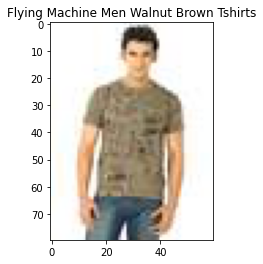

[2] (0.28413403034210205) tags: {'articleType': 'Tshirts', 'year': 2011.0, 'season': 'Fall', 'subCategory': 'Topwear', 'gender': 'Men', 'masterCategory': 'Apparel', 'usage': 'Casual', 'productDisplayName': 'Wrangler Men Polo Charcoal T-shirt', 'baseColour': 'Brown'}


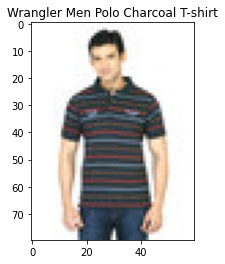

[3] (0.3570515513420105) tags: {'subCategory': 'Topwear', 'articleType': 'Tshirts', 'year': 2011.0, 'baseColour': 'Brown', 'gender': 'Men', 'productDisplayName': 'Classic Polo Classic Polo Swiss Brown Tee T-Shirt', 'season': 'Summer', 'masterCategory': 'Apparel', 'usage': 'Casual'}


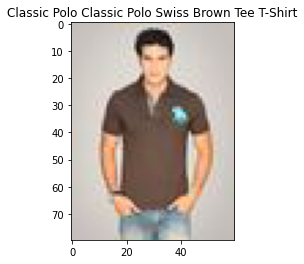

[4] (0.3795245885848999) tags: {'gender': 'Women', 'masterCategory': 'Apparel', 'season': 'Summer', 'productDisplayName': 'W Women Brown Kurta', 'baseColour': 'Brown', 'usage': 'Ethnic', 'subCategory': 'Topwear', 'year': 2012.0, 'articleType': 'Kurtas'}


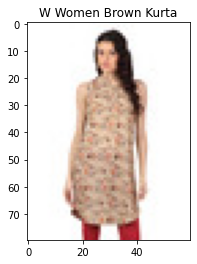

In [13]:
query = docs[:1]
index.search(query, 
             filter={
                 'year': {'$lte': befor_year}, 
                 'masterCategory': {'$eq': category},
                 'baseColour': {'$eq': color}
                }, 
             limit=5, 
             include_metadata=True)


img = Image.open(query[0].uri)
imshow(img)
plt.title(f'Query: {query[0].tags["productDisplayName"]}')
plt.show()
for doc in query:
    for k, match in enumerate(doc.matches):
        print(f'[{k}] ({match.scores["cosine"].value}) tags: {dict(match.tags)}')
        img = Image.open(match.uri)
        imshow(img)
        plt.title(f'{match.tags["productDisplayName"]}')
        plt.show()